In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=8ea5a5f94887be2925851892c57fa7c31cbac7d1cad9df2704ef70a6893b0a4e
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


Shape of bbox_coords: (8, 5)
Shape of bbox_coords: (17, 5)
Shape of bbox_coords: (3, 5)
Shape of bbox_coords: (7, 5)
Shape of bbox_coords: (13, 5)
Shape of bbox_coords: (2, 5)
Shape of bbox_coords: (9, 5)
Shape of bbox_coords: (7, 5)
Shape of bbox_coords: (8, 5)
Shape of bbox_coords: (12, 5)
Shape of bbox_coords: (3, 5)
Shape of bbox_coords: (10, 5)
Shape of bbox_coords: (4, 5)
Shape of bbox_coords: (15, 5)
Shape of bbox_coords: (3, 5)
Shape of bbox_coords: (3, 5)
Shape of bbox_coords: (13, 5)
Shape of bbox_coords: (8, 5)
Shape of bbox_coords: (20, 5)
Shape of bbox_coords: (7, 5)
Incorrect coordinates/ No bounding boxes
Shape of bbox_coords: (16, 5)
Shape of bbox_coords: (18, 5)
Shape of bbox_coords: (4, 5)
Incorrect coordinates/ No bounding boxes
Shape of bbox_coords: (17, 5)
Shape of bbox_coords: (12, 5)
Shape of bbox_coords: (3, 5)
Shape of bbox_coords: (8, 5)
Shape of bbox_coords: (10, 5)
Shape of bbox_coords: (6, 5)
Shape of bbox_coords: (14, 5)
Shape of bbox_coords: (13, 5)
Shape

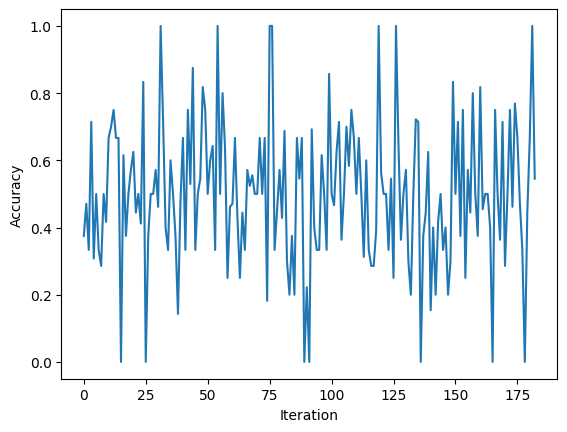

In [ ]:
import os
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import Data
import matplotlib.pyplot as plt

# Define the path to the folder containing the .npy files with bounding box coordinates
bbox_dir = "/content/drive/MyDrive/bounding_box"

# Define GNN parameters
in_channels = 5  # X, Y coordinates of the top-left and bottom-right corners of each bounding box
hidden_channels = 32
out_channels = 2  # Replace with the number of output classes

# Build the GNN
class MyGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MyGNN, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        return torch.nn.functional.log_softmax(x, dim=1)

model = MyGNN(in_channels, hidden_channels, out_channels)

# Define the optimizer and the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Define a list to record accuracies at each iteration
accuracies = []

# # Loop over the .npy files in the folder
# for file_name in os.listdir(bbox_dir):
#     if file_name.endswith(".npy"):
#         # Load the bounding box coordinates
#         bbox_coords = np.load(os.path.join(bbox_dir, file_name))
#         num_boxes = bbox_coords.shape[0]

# Loop over the .npy files in the folder
for file_name in os.listdir(bbox_dir):
    if file_name.endswith(".npy"):
        # Load the bounding box coordinates
        bbox_coords = np.load(os.path.join(bbox_dir, file_name))
        if bbox_coords.shape == (0,) or bbox_coords.shape == (1,5):
            print("Incorrect coordinates/ No bounding boxes")
            continue
        bbox_coords[:, -1] = [color_mapping[color.lower()] for color in bbox_coords[:, -1]]
        bbox_coords = bbox_coords.astype(float)
        size_of_bbox_coords = bbox_coords.shape
        print("Shape of bbox_coords:", size_of_bbox_coords)
        num_boxes = bbox_coords.shape[0]

        # Initialize node features with bounding box coordinates
        node_features = torch.tensor(bbox_coords, dtype=torch.float)

        # Compute edge features as the Euclidean distance between bounding boxes
        edge_indices = []
        edge_features = []
        for i in range(num_boxes):
            for j in range(i+1, num_boxes):
                edge_indices.append([i, j])
                edge_features.append(torch.norm(node_features[i] - node_features[j]))
        edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_features = torch.stack(edge_features)

        # Create a PyTorch Geometric Data object from the node features and edge features
        graph_data = Data(x=node_features, edge_index=edge_indices, edge_attr=edge_features)

        # Zero out the gradients
        optimizer.zero_grad()

        # Run the graph through the GNN and make predictions
        predictions = model(graph_data.x, graph_data.edge_index)

        # Generate random labels for each bounding box for accuracy calculation
        random_labels = torch.randint(low=0, high=out_channels, size=(num_boxes,))

        # Calculate the loss and accuracy of the predictions
        loss = criterion(predictions, random_labels)
        accuracy = (predictions.argmax(dim=1) == random_labels).sum().item() / num_boxes

        # Backpropagate the gradients and update the parameters
        loss.backward()
        optimizer.step()

        # Record the accuracy
        accuracies.append(accuracy)

# Generate a line plot of the accuracies over time
plt.plot(accuracies)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
import cv2
import numpy as np
import os

# Define the path to the folder containing the images
image_dir = '/content/drive/MyDrive/100_images_dataset_malaria'
result = "/content/drive/MyDrive/bounding_box_img"

# Define the parameters for K-means clustering
k = 15

# Define the colors for the bounding boxes
rbc_color = (0, 0, 255)   # Red
wbc_color = (255, 0, 0)   # Blue

# Loop over the images in the folder
for file_name in os.listdir(image_dir):
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        # Load the image
        image = cv2.imread(os.path.join(image_dir, file_name))

        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply a Gaussian blur to remove noise
        blur = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply a threshold to segment the image
        _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find the coordinates of the foreground pixels
        coordinates = np.transpose(np.nonzero(thresh))

        # Apply K-means clustering to group the coordinates into K clusters
        kmeans = cv2.kmeans(coordinates.astype(np.float32), k, None,
                            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                            attempts=10,
                            flags=cv2.KMEANS_RANDOM_CENTERS)

        # Loop over the clusters and draw bounding boxes around them
        for i in range(k):
            # Find the coordinates of the pixels in the cluster
            cluster_pixels = coordinates[kmeans[1].flatten() == i]

            # Compute the bounding box for the cluster
            x, y, w, h = cv2.boundingRect(cluster_pixels)

            # Extract the region of interest from the original image
            roi = image[y:y+h, x:x+w]

            # Compute the mean color of the region of interest
            mean_color = np.mean(roi, axis=(0, 1))

            # Classify the bounding box based on its color
            if mean_color[2] > mean_color[0] and mean_color[2] > mean_color[1]:
                # Red bounding box for RBC
                cv2.rectangle(image, (x, y), (x+w, y+h), rbc_color, 2)
            else:
                # Blue bounding box for WBC
                cv2.rectangle(image, (x, y), (x+w, y+h), wbc_color, 2)

        # Save the image with the bounding boxes
        cv2.imwrite(os.path.join(result, "result_" + file_name), image)

In [ ]:
import cv2
import numpy as np
import os

# Define the path to the folder containing the images
image_dir = '/content/drive/MyDrive/100_images_dataset_malaria'
result = "/content/drive/MyDrive/bounding_box_img"
# Define the path to the folder to save the labels and coordinates
label_dir = "/content/drive/MyDrive/bounding_box"

# Create the directory if it does not exist
if not os.path.exists(label_dir):
    os.makedirs(label_dir)

# Define the parameters for K-means clustering
k = 15

# Define the colors for the bounding boxes
rbc_color = (0, 0, 255)   # Red
wbc_color = (255, 0, 0)   # Blue

# Loop over the images in the folder
for file_name in os.listdir(image_dir):
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        # Load the image
        image = cv2.imread(os.path.join(image_dir, file_name))

        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply a Gaussian blur to remove noise
        blur = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply a threshold to segment the image
        _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find the coordinates of the foreground pixels
        coordinates = np.transpose(np.nonzero(thresh))

        # Apply K-means clustering to group the coordinates into K clusters
        kmeans = cv2.kmeans(coordinates.astype(np.float32), k, None,
                            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                            attempts=10,
                            flags=cv2.KMEANS_RANDOM_CENTERS)

        # Loop over the clusters and draw bounding boxes around them
        for i in range(k):
            # Find the coordinates of the pixels in the cluster
            cluster_pixels = coordinates[kmeans[1].flatten() == i]

            # Compute the bounding box for the cluster
            x, y, w, h = cv2.boundingRect(cluster_pixels)

            # Extract the region of interest from the original image
            roi = image[y:y+h, x:x+w]

            # Compute the mean color of the region of interest
            mean_color = np.mean(roi, axis=(0, 1))

            # Classify the bounding box based on its color
            if mean_color[2] > mean_color[0] and mean_color[2] > mean_color[1]:
                # Red bounding box for RBC
                cv2.rectangle(image, (x, y), (x+w, y+h), rbc_color, 2)
                label = "RBC"
            else:
                # Blue bounding box for WBC
                cv2.rectangle(image, (x, y), (x+w, y+h), wbc_color, 2)
                label = "WBC"

            # Save the label and coordinates of the bounding box to file
            label_file = os.path.splitext(file_name)[0] + "_" + str(i) + ".txt"
            label_path = os.path.join(label_dir, label_file)
            with open(label_path, "w") as f:
                f.write("{} {} {} {} {}\n".format(label, x, y, x+w, y+h))

        # Save the image with the bounding boxes
        result_file = "result_" + file_name
        result_path = os.path.join(result, result_file)
        cv2.imwrite(result_path, image)

In [ ]:
import cv2
import numpy as np
import os

# Define the path to the folder containing the images
image_dir = '/content/drive/MyDrive/100_images_dataset_malaria'
result = "/content/drive/MyDrive/bounding_box_img"
# Define the path to the folder to save the labels and coordinates
label_dir = "/content/drive/MyDrive/bounding_box"

# Create the directory if it does not exist
if not os.path.exists(label_dir):
    os.makedirs(label_dir)

# Define the parameters for K-means clustering
k = 15

# Define the colors for the bounding boxes
rbc_color = (0, 0, 255)   # Red
wbc_color = (255, 0, 0)   # Blue

# Loop over the images in the folder
for file_name in os.listdir(image_dir):
    if file_name.endswith(".jpg") or file_name.endswith(".png"):
        # Load the image
        image = cv2.imread(os.path.join(image_dir, file_name))

        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply a Gaussian blur to remove noise
        blur = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply a threshold to segment the image
        _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Find the coordinates of the foreground pixels
        coordinates = np.transpose(np.nonzero(thresh))

        # Apply K-means clustering to group the coordinates into K clusters
        kmeans = cv2.kmeans(coordinates.astype(np.float32), k, None,
                            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                            attempts=10,
                            flags=cv2.KMEANS_RANDOM_CENTERS)

        # Loop over the clusters and draw bounding boxes around them
        for i in range(k):
            # Find the coordinates of the pixels in the cluster
            cluster_pixels = coordinates[kmeans[1].flatten() == i]

            # Compute the bounding box for the cluster
            x, y, w, h = cv2.boundingRect(cluster_pixels)

            # Extract the region of interest from the original image
            roi = image[y:y+h, x:x+w]

            # Compute the mean color of the region of interest
            mean_color = np.mean(roi, axis=(0, 1))

            # Classify the bounding box based on its color
            if mean_color[2] > mean_color[0] and mean_color[2] > mean_color[1]:
                # Red bounding box for RBC
                cv2.rectangle(image, (x, y), (x+w, y+h), rbc_color, 2)
                label = "RBC"
            else:
                # Blue bounding box for WBC
                cv2.rectangle(image, (x, y), (x+w, y+h), wbc_color, 2)
                label = "WBC"

            # Save the label and coordinates of the bounding box to file
            label_file = os.path.splitext(file_name)[0] + "_" + str(i) + ".txt"
            label_path = os.path.join(label_dir, label_file)
            with open(label_path, "w") as f:
                f.write("{} {} {} {} {}\n".format(label, x, y, x+w, y+h))

        # Save the image with the bounding boxes
        result_file = "result_" + file_name
        result_path = os.path.join(result, result_file)
        cv2.imwrite(result_path, image)

###The above code helps with clustering of images after drawing the bounding boxes. Now we need to load these node and edge features and construct a graph.

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch.nn import ReLU, BatchNorm1d, Sequential

# Define the path to the directory containing the bounding box image files
bounding_box_img_dir = "/content/drive/MyDrive/bounding_box"

# Define a dictionary to store the WBC/RBC ratios for each image
image_ratios = {}

# Iterate through the images
for image_num in range(1, 121):
    image_name = f"image-{image_num}"

    # Initialize counters for WBC and RBC
    wbc_count = 0
    rbc_count = 0

    # Iterate through .txt files for each image
    for txt_file in os.listdir(bounding_box_img_dir):
        if txt_file.startswith(image_name) and txt_file.endswith(".txt"):
            txt_file_parts = txt_file[:-4].split('_')
            box_num = int(txt_file_parts[1])
            # print(box_num)
            # Read the content of the .txt file
            with open(os.path.join(bounding_box_img_dir, txt_file), "r") as f:
                line = f.readline().strip().split()
                label = line[0]

                if label == "WBC":
                    wbc_count += 1
                elif label == "RBC":
                    rbc_count += 1
    # print(wbc_count)
    # print(rbc_count)
    # Calculate the WBC/RBC ratio for this image
    ratio = wbc_count / rbc_count if rbc_count != 0 else float("inf")
    image_ratios[image_name] = ratio

for image_num in range(1,121):
  image_name = f"image-{image_num}"
  # print(f"{image_num} : {image_ratios[image_name]}")
# Create a graph representation of the data
num_nodes = len(image_ratios)
print(num_nodes)
adj = np.zeros((num_nodes, num_nodes))

# Initialize the edges and adjacency matrix
edges = []

for i in range(120):
  for j in range(120):
    image_name = f"image-{i+1}"
    adj[i,j] = image_ratios[image_name]
for i in range(num_nodes):
  for j in range(num_nodes):
    weight = adj[i,j]
    print(f"Edge: {i+1} -> {j+1}, Weight: {weight}")




# Convert adjacency matrix to upper triangular form
# adj = adj + adj.T - np.diag(adj.diagonal())

# edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()



Streaming output truncated to the last 5000 lines.
Edge: 79 -> 41, Weight: inf
Edge: 79 -> 42, Weight: inf
Edge: 79 -> 43, Weight: inf
Edge: 79 -> 44, Weight: inf
Edge: 79 -> 45, Weight: inf
Edge: 79 -> 46, Weight: inf
Edge: 79 -> 47, Weight: inf
Edge: 79 -> 48, Weight: inf
Edge: 79 -> 49, Weight: inf
Edge: 79 -> 50, Weight: inf
Edge: 79 -> 51, Weight: inf
Edge: 79 -> 52, Weight: inf
Edge: 79 -> 53, Weight: inf
Edge: 79 -> 54, Weight: inf
Edge: 79 -> 55, Weight: inf
Edge: 79 -> 56, Weight: inf
Edge: 79 -> 57, Weight: inf
Edge: 79 -> 58, Weight: inf
Edge: 79 -> 59, Weight: inf
Edge: 79 -> 60, Weight: inf
Edge: 79 -> 61, Weight: inf
Edge: 79 -> 62, Weight: inf
Edge: 79 -> 63, Weight: inf
Edge: 79 -> 64, Weight: inf
Edge: 79 -> 65, Weight: inf
Edge: 79 -> 66, Weight: inf
Edge: 79 -> 67, Weight: inf
Edge: 79 -> 68, Weight: inf
Edge: 79 -> 69, Weight: inf
Edge: 79 -> 70, Weight: inf
Edge: 79 -> 71, Weight: inf
Edge: 79 -> 72, Weight: inf
Edge: 79 -> 73, Weight: inf
Edge: 79 -> 74, Weight: i

In [ ]:
print(nodes)

[[118, 138, 190, 207], [206, 0, 256, 73], [0, 172, 41, 256], [0, 65, 45, 142], [160, 50, 241, 108], [56, 134, 95, 194], [37, 214, 107, 256], [180, 89, 256, 177], [43, 92, 106, 140], [57, 0, 125, 81], [151, 0, 212, 59], [151, 0, 230, 63], [137, 190, 206, 256], [81, 166, 140, 256], [180, 169, 256, 256], [14, 183, 89, 256], [211, 99, 256, 140], [190, 139, 256, 180], [191, 40, 246, 93], [107, 39, 177, 109], [106, 109, 190, 185], [0, 0, 62, 43], [148, 81, 214, 152], [0, 94, 87, 188], [54, 81, 125, 146], [64, 85, 118, 136], [166, 214, 256, 256], [53, 41, 106, 93], [23, 0, 101, 52], [102, 157, 184, 256], [193, 165, 256, 223], [100, 31, 167, 112], [37, 229, 126, 256], [49, 132, 121, 188], [0, 123, 23, 225], [133, 0, 202, 58], [0, 25, 54, 123], [186, 121, 256, 175], [154, 55, 256, 128], [194, 0, 256, 76], [48, 121, 107, 194], [177, 116, 249, 190], [0, 98, 62, 165], [0, 207, 77, 256], [0, 1, 38, 99], [0, 161, 50, 214], [76, 4, 122, 66], [156, 191, 256, 256], [36, 38, 101, 90], [168, 0, 256, 68],

###Input Graph

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch.nn import ReLU, BatchNorm1d, Sequential

# Define the path to the label folder
label_dir = "/content/drive/MyDrive/bounding_box"
image_dir = "/content/drive/MyDrive/bounding_box_img"
# Load the labeled bounding boxes and create a graph representation of the data
nodes = []
edges = []
labels = []
for file_name in os.listdir(label_dir):
    if file_name.endswith(".txt"):
        with open(os.path.join(label_dir, file_name), "r") as f:
            line = f.readline().strip().split()
            label = int(line[0] == "WBC")   # Convert the label to a binary value
            x1, y1, x2, y2 = [int(x) for x in line[1:]]
            nodes.append([x1, y1, x2, y2])
            labels.append(label)

# # Create a graph representation of the data
num_nodes = len(nodes)
adj = np.zeros((num_nodes, num_nodes))

import os

# Define the path to the directory containing the bounding box .txt files
bounding_box_dir = "/content/drive/MyDrive/bounding_box"

# Define a dictionary to store the WBC/RBC ratios for each image
image_ratios = {}

# Iterate through the images
for image_num in range(1, 121):
    image_name = f"image-{image_num}"

    # Initialize counters for WBC and RBC
    wbc_count = 0
    rbc_count = 0

    # Iterate through .txt files for each image
    for txt_file in os.listdir(bounding_box_dir):
        if txt_file.startswith(image_name) and txt_file.endswith(".txt"):
            txt_file_parts = txt_file[:-4].split('_')
            box_num = int(txt_file_parts[1])

            # Read the content of the .txt file
            with open(os.path.join(bounding_box_dir, txt_file), "r") as f:
                line = f.readline().strip().split()
                label = line[0]

                if label == "WBC":
                    wbc_count += 1
                elif label == "RBC":
                    rbc_count += 1

    # Calculate the WBC/RBC ratio for this image
    ratio = wbc_count / rbc_count if rbc_count != 0 else float("inf")
    image_ratios[image_name] = ratio

# Initialize the edges and adjacency matrix
edges = []
adj = np.zeros((num_nodes, num_nodes))

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if labels[i] == 1 and labels[j] == 0:
            weight = image_ratios[f"image-{i+1}"]  # Use WBC/RBC ratio for the first image
        elif labels[i] == 0 and labels[j] == 1:
            weight = image_ratios[f"image-{j+1}"]  # Use WBC/RBC ratio for the second image
        else:
            distance = np.sqrt((nodes[i][0] - nodes[j][0])**2 + (nodes[i][1] - nodes[j][1])**2)
            weight = distance  # Use distance as weight for non-related nodes

        edges.append([i, j])
        adj[i, j] = weight

# Convert adjacency matrix to upper triangular form
adj = adj + adj.T - np.diag(adj.diagonal())

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

















from torch_geometric.data import Data
x = torch.tensor(nodes, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.float).view(-1, 1)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
data = Data(x=x, edge_index=edge_index, y=y)
loader = DataLoader([data], batch_size=1)

# Define the GNN model
from torch_geometric.nn import MessagePassing
from torch.nn import Linear


# Define the GNN model
class DenseGNN(MessagePassing):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__(aggr='add')
        self.mlp1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden_channels), torch.nn.ReLU(), torch.nn.BatchNorm1d(hidden_channels))
        self.mlp2 = torch.nn.Sequential(torch.nn.Linear(hidden_channels, hidden_channels), torch.nn.ReLU(), torch.nn.BatchNorm1d(hidden_channels))
        self.mlp3 = torch.nn.Sequential(torch.nn.Linear(hidden_channels, out_channels), torch.nn.ReLU(), torch.nn.BatchNorm1d(out_channels))

    def forward(self, x, edge_index):
        x = self.mlp1(x)
        x = self.propagate(edge_index, x=x)
        x = self.mlp2(x)
        x = self.propagate(edge_index, x=x)
        x = self.mlp3(x)
        return x

    def message(self, x_j):
        return x_j

model = DenseGNN(in_channels=4, hidden_channels=16, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Define variables for accuracy tracking and plotting
losses, accuracies = [], []
fig, ax = plt.subplots()

for epoch in range(100):
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = F.binary_cross_entropy_with_logits(out, batch.y)
        loss.backward()
        optimizer.step()

        # Compute accuracy for the current batch
        pred = (torch.sigmoid(out) > 0.5).float()
        accuracy = (pred == batch.y).float().mean().item()
        accuracies.append(accuracy)

    # Compute the average loss and accuracy over all batches for this epoch
    avg_loss = loss.item()
    avg_accuracy = np.mean(accuracies)
    losses.append(avg_loss)

    # Print the loss and accuracy for this epoch
    print(f'Epoch {epoch+1}/{100}, Loss: {loss:.6f}, Accuracy: {avg_accuracy:.6f}')

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the final accuracy graph
fig, ax = plt.subplots()
ax.plot(range(len(accuracies)), accuracies, 'b-')
ax.set_xlabel('Batch')
ax.set_ylabel('Accuracy')
plt.show()

torch.save(model.state_dict(), '/content/drive/MyDrive/BinaryClassModel1')

In [ ]:
print(image_ratios)

{'image-1': 0.21508379888268156, 'image-2': 0.22448979591836735, 'image-3': 0.3157894736842105, 'image-4': 0.15384615384615385, 'image-5': 0.15384615384615385, 'image-6': 0.17647058823529413, 'image-7': 0.41025641025641024, 'image-8': 0.8539325842696629, 'image-9': 0.2857142857142857, 'image-10': 0.14583333333333334, 'image-11': 0.32, 'image-12': 0.36363636363636365, 'image-13': inf, 'image-14': 0.07142857142857142, 'image-15': inf, 'image-16': inf, 'image-17': 0.5, 'image-18': 0.15384615384615385, 'image-19': 0.0, 'image-20': 0.0, 'image-21': 0.25, 'image-22': 0.25, 'image-23': 0.36363636363636365, 'image-24': 0.36363636363636365, 'image-25': 0.07142857142857142, 'image-26': inf, 'image-27': inf, 'image-28': 0.25, 'image-29': inf, 'image-30': 0.15384615384615385, 'image-31': inf, 'image-32': 0.07142857142857142, 'image-33': 0.07142857142857142, 'image-34': 0.0, 'image-35': 0.0, 'image-36': 0.5, 'image-37': 0.25, 'image-38': 0.15384615384615385, 'image-39': 0.875, 'image-40': inf, 'ima

In [ ]:
import os
import torch
import numpy as np
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F

# Define the path to the label folder
label_dir = "/content/drive/MyDrive/bounding_box"

# Define the GNN model
class DenseGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(DenseGNN, self).__init__()
        self.mlp1 = torch.nn.Sequential(torch.nn.Linear(in_channels, hidden_channels), torch.nn.ReLU(), torch.nn.BatchNorm1d(hidden_channels))
        self.mlp2 = torch.nn.Sequential(torch.nn.Linear(hidden_channels, hidden_channels), torch.nn.ReLU(), torch.nn.BatchNorm1d(hidden_channels))
        self.mlp3 = torch.nn.Sequential(torch.nn.Linear(hidden_channels, out_channels), torch.nn.ReLU(), torch.nn.BatchNorm1d(out_channels))

    def forward(self, x, edge_index):
        x = self.mlp1(x)
        x = self.propagate(edge_index, x=x)
        x = self.mlp2(x)
        x = self.propagate(edge_index, x=x)
        x = self.mlp3(x)
        return x

    def message(self, x_j):
        return x_j

# Loop through images
for image_file in os.listdir(label_dir):
    if image_file.endswith(".txt"):
        # Load the labeled bounding boxes and create a graph representation of the data
        nodes = []
        edges = []
        labels = []
        for image_num in range(1, 121):  # Assuming you have 120 images
            image_name = f"image{image_num}"
            image_txt_dir = os.path.join(image_dir, image_name)
            for txt_file in os.listdir(image_txt_dir):
              if txt_file.endswith(".txt"):
                txt_file_path = os.path.join(image_txt_dir, txt_file)
            # with open(os.path.join(label_dir, image_file), "r") as f:
                with open(txt_file_path,'r'):
                  for line in f:
                      line = line.strip().split()
                      label = int(line[0] == "WBC")   # Convert the label to a binary value
                      x1, y1, x2, y2 = [int(x) for x in line[1:]]
                      nodes.append([x1, y1, x2, y2])
                      labels.append(label)

        # Calculate the ratio of WBCs to RBCs in the image
        num_wbc = sum(labels)
        num_rbc = len(labels) - num_wbc
        ratio = num_wbc / num_rbc

        # Create a graph representation of the data
        num_nodes = len(nodes)
        adj = np.zeros((num_nodes, num_nodes))
        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                if labels[i] == 1 and labels[j] == 0:
                    weight = ratio
                elif labels[i] == 0 and labels[j] == 1:
                    weight = 1 / ratio
                else:
                    distance = np.sqrt((nodes[i][0] - nodes[j][0])**2 + (nodes[i][1] - nodes[j][1])**2)
                    weight = distance
                edges.append([i, j])
                adj[i, j] = weight
                adj[j, i] = weight
            adj[i, i] = 1

        from torch_geometric.data import Data
        x = torch.tensor(nodes, dtype=torch.float)
        y = torch.tensor(labels, dtype=torch.float).view(-1, 1)
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        data = Data(x=x, edge_index=edge_index, y=y)
        loader = DataLoader([data], batch_size=1)

        # Define variables for accuracy tracking and plotting
        model = DenseGNN(in_channels=4, hidden_channels=16, out_channels=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

        losses, accuracies = [], []

        for epoch in range(200):
            for batch in loader:
                optimizer.zero_grad()
                out = model(batch.x, batch.edge_index)
                loss = F.binary_cross_entropy_with_logits(out, batch.y)
                loss.backward()
                optimizer.step()

                # Compute accuracy for the current batch
                pred = (torch.sigmoid(out) > 0.5).float()
                accuracy = (pred == batch.y).float().mean().item()
                accuracies.append(accuracy)

            avg_loss = loss.item()
            avg_accuracy = np.mean(accuracies)
            losses.append(avg_loss)

            print(f'Epoch {epoch+1}/{100}, Loss: {loss:.6f}, Accuracy: {avg_accuracy:.6f}')

        # Save the trained model for this image
        torch.save(model.state_dict(), f'model_{image_file[:-4]}.pth')
